In [1]:
import numpy as np
import pickle
import pandas as pd
import os
from os.path import join
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score
from scipy import stats
import xgboost as xgb

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
# plt.style.use('CCB_plot_style_0v4.mplstyle')
# c_styles      = mpl.rcParams['axes.prop_cycle'].by_key()['color']   # fetch the defined color styles
# high_contrast = ['#004488', '#DDAA33', '#BB5566', '#000000']

c:\Users\marle\anaconda3\envs\py37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\marle\anaconda3\envs\py37\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\Users\marle\anaconda3\envs\py37\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


## Loading training, testing and validation data:

In [12]:
data_train = pd.read_pickle(join("..", "..", "data", "train_df_Km_Seed plants.pkl"))
data_test = pd.read_pickle(join("..", "..", "data", "test_df_Km_Seed plants.pkl"))
data_val = pd.read_pickle(join("..", "..", "data", "validation_Seed plants.pkl"))

# data_train["geomean_Km"] = np.log10(data_train["geomean_Km"])
# data_test["geomean_Km"] = np.log10(data_test["geomean_Km"])

data_train["log10_Km"] = np.log10(data_train["Km"])
data_test["log10_Km"] = np.log10(data_test["Km"])
data_val["log10_Km"] = np.log10(data_val["Km"])

data_train.rename(columns = {"Enzyme rep" : "ESM2"}, inplace = True)
data_test.rename(columns = {"Enzyme rep" : "ESM2"}, inplace = True)

data_train['Temperature'] = data_train['Temperature'].replace('-', np.nan)
data_test['Temperature'] = data_test['Temperature'].replace('-', np.nan)
data_val['Temperature'] = data_val['Temperature'].replace('-', np.nan)
data_train['pH'] = data_train['pH'].replace('-', np.nan)
data_test['pH'] = data_test['pH'].replace('-', np.nan)
data_val['pH'] = data_val['pH'].replace('-', np.nan)
data_train['Type'] = data_train['Type'].replace('wildtype', 1)
data_train['Type'] = data_train['Type'].replace('mutant', 2)
data_test['Type'] = data_test['Type'].replace('wildtype', 1)
data_test['Type'] = data_test['Type'].replace('mutant', 2)
data_val['Type'] = data_val['Type'].replace('wildtype', 1)
data_val['Type'] = data_val['Type'].replace('mutant', 2)

data_train['MACCS FP'] = data_train['MACCS FP'].astype(str)
data_test['MACCS FP'] = data_test['MACCS FP'].astype(str)
data_val['MACCS FP'] = data_val['MACCS FP'].astype(str)

len(data_train), len(data_test), len(data_val)

(517, 105)

In [13]:
train_indices = list(np.load(join("..", "..", "data", "CV_train_indices_Seed plants.npy"), allow_pickle = True))
test_indices = list(np.load(join("..", "..", "data", "CV_test_indices_Seed plants.npy"), allow_pickle = True))

## 1. Training a model with enzyme and main substrate information (ESM-2/MACCS) + Temperature + pH :

#### (a) Creating input matrices:

In [14]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array([list(s) for s in data_train['MACCS FP']]), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array([list(s) for s in data_test['MACCS FP']]), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [ ]:
def cross_validation_mse_gradient_boosting(param):
    num_round = param["num_rounds"]
    del param["num_rounds"]
    param["max_depth"] = int(np.round(param["max_depth"]))
    # param["device"] = "cuda"
    param["tree_method"] = "hist"
    param["sampling_method"] = "gradient_based"
    
    MSE = []
    R2 = []
    for i in range(5):
        train_index, test_index  = train_indices[i], test_indices[i]
        dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
        dvalid = xgb.DMatrix(train_X[test_index])
        bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
        y_valid_pred = bst.predict(dvalid)
        MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
        R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
    return(-np.mean(R2))


from hyperopt import fmin, tpe, rand, hp, Trials

space_gradient_boosting = {
    "learning_rate": hp.choice("learning_rate", np.linspace(0.01, 0.1, 10)),
    "max_depth": hp.choice("max_depth", np.linspace(3,10,7)),
    #"subsample": hp.quniform("subsample", 0.5, 1),
    "reg_lambda": hp.choice("reg_lambda", np.linspace(0, 1, 10)),
    "reg_alpha": hp.choice("reg_alpha", np.linspace(0, 1, 10)),
    "max_delta_step": hp.choice("max_delta_step", np.linspace(1, 5, 5)),
    "min_child_weight": hp.choice("min_child_weight", np.linspace(1, 6, 6)),
    "num_rounds":  hp.choice("num_rounds", np.linspace(50, 200, 4))}


trials = Trials()
best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
            algo=rand.suggest, max_evals = 10, trials=trials)

In [18]:
print(best)

{'learning_rate': 0.055115325102336195, 'max_delta_step': 4.3782574746699785, 'max_depth': 8.234288018350421, 'min_child_weight': 3.197892054267437, 'num_rounds': 169.11296626727352, 'reg_alpha': 0.45172341759748236, 'reg_lambda': 0.7434118607991583}


{'learning_rate': 0.055115325102336195, 'max_delta_step': 4.3782574746699785, 'max_depth': 8.234288018350421, 'min_child_weight': 3.197892054267437, 'num_rounds': 169.11296626727352, 'reg_alpha': 0.45172341759748236, 'reg_lambda': 0.7434118607991583}

#### (c) Training and validating model:

In [15]:
param = {"random_state": 42, 
         'learning_rate': 0.055115325102336195, 
         'max_delta_step': 4.3782574746699785, 
         'max_depth': 8.234288018350421, 
         'min_child_weight': 3.197892054267437, 
         'num_rounds': 169.11296626727352, 
         'reg_alpha': 0.45172341759748236, 
         'reg_lambda': 0.7434118607991583}

num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [7]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred])))
    MedAE.append(np.median(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred])))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(R2))

KeyboardInterrupt: 

In [16]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate Km"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", "y_test_pred_xgboost_ESM1b_ts_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_ESM1b_ts_diff_fp.npy"), test_Y)

0.2 0.0013249325 -0.04 0.0005013069 9.69164e-05


In [65]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate Km"] = [10**x for x in data_test["Estimate Km"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

,Reaction ID,Sequence ID,Temperature,pH,Type,Main substrate,Km_values,Uniprot IDs,ECs,Substrates,Products,ESM2,Sequence,difference_fp,structural_fp,log10_Km,Estimate Km
46,Reaction_513,Sequence_525,33.0,8.3,1,0000000000000000000000000000000000000000000000...,[0.00092628],[Q9LE06],[2.6.1.88],L-Methionine;2-Oxoglutarate;,4-Methylthio-2-oxobutanoate;L-Glutamate;,"[0.010767821, -0.016377859, -0.05220723, 0.002...",MAPSAQPLPVSVSDEKYANVKWEELAFKFVRTDYMYVAKCNHGESF...,"[0.0, 0.0, 0.0, 0.0, -20.0, 0.0, 0.0, 0.0, 0.0...",1000000000000000000000000000000001000001001000...,-3.033258,0.000535
96,Reaction_515,Sequence_525,33.0,8.3,1,0000000000000000000000000000000000000000000000...,[4.52e-05],[Q9LE06],[2.6.1.88],4-Methylthio-2-oxobutanoate;L-Glutamate;,L-Methionine;2-Oxoglutarate;,"[0.010767821, -0.016377859, -0.05220723, 0.002...",MAPSAQPLPVSVSDEKYANVKWEELAFKFVRTDYMYVAKCNHGESF...,"[0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0,...",1000000000000000000000000000000001000001001000...,-4.344862,0.000085


#### (d) Training model with test and train data for production mode:

In [27]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array([list(s) for s in data_train['MACCS FP']]), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array([list(s) for s in data_test['MACCS FP']]), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [28]:
param = {"random_state": 42, 
         'learning_rate': 0.055115325102336195, 
         'max_delta_step': 4.3782574746699785, 
         'max_depth': 8.234288018350421, 
         'min_child_weight': 3.197892054267437, 
         'num_rounds': 169.11296626727352, 
         'reg_alpha': 0.45172341759748236, 
         'reg_lambda': 0.7434118607991583}

num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.8615311803627979, 2.592247953387984e-38) 0.0007210631060349314 0.691099904743456


In [9]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

1280
167


{'f0': 14.0,
 'f1': 19.0,
 'f2': 33.0,
 'f3': 16.0,
 'f4': 31.0,
 'f5': 16.0,
 'f6': 18.0,
 'f7': 21.0,
 'f8': 13.0,
 'f9': 7.0,
 'f10': 12.0,
 'f11': 14.0,
 'f12': 22.0,
 'f13': 16.0,
 'f14': 5.0,
 'f15': 6.0,
 'f16': 11.0,
 'f17': 24.0,
 'f18': 17.0,
 'f19': 6.0,
 'f20': 11.0,
 'f21': 9.0,
 'f22': 9.0,
 'f23': 5.0,
 'f24': 17.0,
 'f25': 3.0,
 'f26': 11.0,
 'f27': 7.0,
 'f28': 9.0,
 'f29': 11.0,
 'f30': 7.0,
 'f31': 6.0,
 'f32': 8.0,
 'f33': 8.0,
 'f34': 7.0,
 'f35': 12.0,
 'f36': 6.0,
 'f37': 8.0,
 'f38': 8.0,
 'f39': 6.0,
 'f40': 10.0,
 'f41': 13.0,
 'f42': 16.0,
 'f43': 5.0,
 'f44': 6.0,
 'f45': 8.0,
 'f46': 27.0,
 'f47': 4.0,
 'f48': 8.0,
 'f49': 6.0,
 'f50': 7.0,
 'f51': 7.0,
 'f52': 8.0,
 'f53': 14.0,
 'f54': 2.0,
 'f55': 7.0,
 'f56': 8.0,
 'f57': 2.0,
 'f58': 3.0,
 'f59': 1.0,
 'f60': 5.0,
 'f61': 10.0,
 'f62': 10.0,
 'f63': 1.0,
 'f64': 4.0,
 'f65': 9.0,
 'f66': 1.0,
 'f67': 20.0,
 'f68': 8.0,
 'f69': 1.0,
 'f70': 4.0,
 'f71': 13.0,
 'f72': 4.0,
 'f73': 4.0,
 'f74': 4.0,
 'f75

##### Validating model:

In [29]:
data_val = pd.read_pickle(join("..", "..", "data", "validation_Seed plants.pkl"))

data_val["geomean_Km"] = np.log10(data_val["geomean_Km"])

data_val.rename(columns = {"geomean_Km" :"log10_Km"}, inplace = True)

data_val['Temperature'] = data_val['Temperature'].replace('-', np.nan)
data_val['pH'] = data_val['pH'].replace('-', np.nan)
data_val['Type'] = data_val['Type'].replace('wildtype', 1)
data_val['Type'] = data_val['Type'].replace('mutant', 2)

data_val['MACCS FP'] = data_val['MACCS FP'].astype(str)

val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array([list(s) for s in data_val['MACCS FP']]), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_Km"]))

val_X = val_X.astype(float)

In [66]:
pd.DataFrame(list(chain(*data_val["Km_values"]))).describe()

,0
count,1465.000000
mean,0.000688
std,0.002105
min,0.000001
25%,0.000021
50%,0.000076
75%,0.000362
max,0.021700


In [31]:
dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate Km"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE)

(0.26185508153226134, 3.7197118842076635e-20) 0.0022505837162184986 -0.022899574542853296 0.00011254769009405519


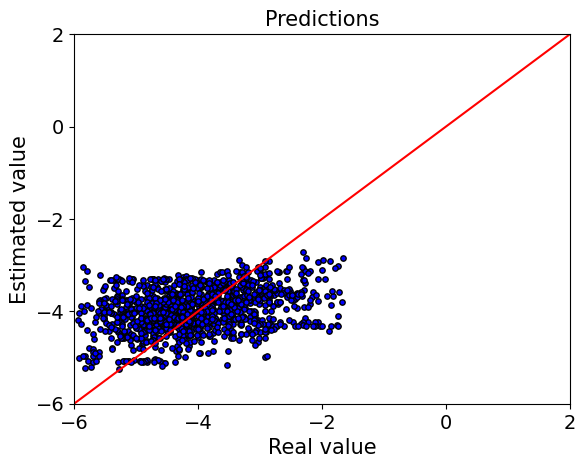

In [85]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

plt.scatter(val_Y,y_val_pred, c='blue', edgecolors='black',s=15)
    
plt.xlim(-6,2)
plt.ylim(-6,2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Real value', fontsize=15)
plt.ylabel('Estimated value', fontsize=15)
plt.title('Predictions', fontsize=15)
plt.axline((1, 1), slope=1, c='red')
plt.show()

In [19]:
data_combined = pd.concat([data_train, data_test],ignore_index=True)

In [28]:
def calculate_identity_ignore_gaps(seq1, seq2):
    identical_residues = sum([1 for x, y in zip(seq1, seq2) if x == y and x != "-"])
    pid = identical_residues / sum([1 for x in seq1 if x != "-"]) 
    return pid

from Bio import Align
from Bio.Align import substitution_matrices

data_val["max_identity"] = np.nan

aligner=Align.PairwiseAligner()
aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")
aligner.mode = "global"
aligner.extend_gap_score = -0.5
aligner.open_gap_score = -10

for i in data_val.index:
    identities = []
    for j in data_combined.index:
        seq1 = str(data_val["Sequence"][i])
        seq2 = str(data_combined["Sequence"][j])
        if 'U' in seq1:
            seq1 = seq1.replace('U', 'C')
        if 'U' in seq2:
            seq2 = seq2.replace('U', 'C')
        alignments = aligner.align(seq1, seq2)
        identities.append(calculate_identity_ignore_gaps(alignments[0][0], alignments[0][1]))
    data_val["max_identity"][i] = max(identities)

In [29]:
data_val["max_identity"] = data_val["max_identity"]*100

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


650
0-40% -0.04845677118086611 0.0022665107519394454
417
40-80% 0.014075629570900583 0.002302032362985863
120
80-99% 0.020723819810246513 0.001694400892875359
8
99-100% -6.307323670239093 0.0043203755508250665


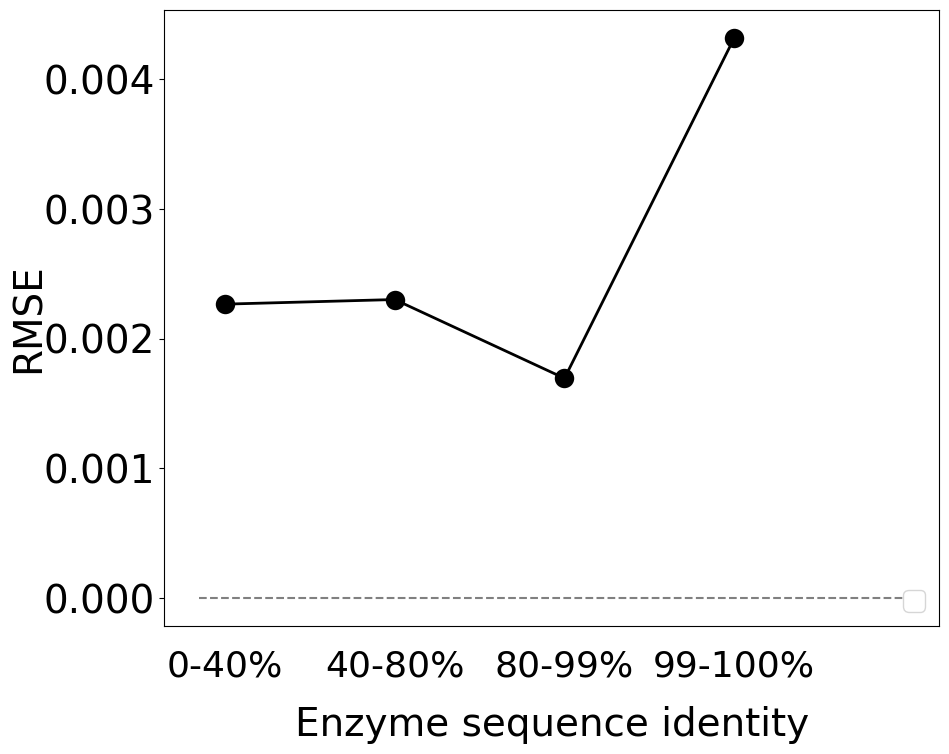

In [33]:
import matplotlib.pyplot as plt
import sklearn.metrics as sk
import math

fig, ax = plt.subplots(figsize= (10,8))
plt.rcParams.update({'font.size': 28})

splits = ["0-40%", "40-80%", "80-99%", "99-100%"]
lower_bounds = [0,40,80,99]
upper_bounds = [40,80,99,100]

points1 = []
points2 = []
n_points1, n_points2 = [], []

for i, split in enumerate(splits):

    lb, ub = lower_bounds[i], upper_bounds[i]
    
    help_df = data_val.loc[data_val["max_identity"]>= lb].loc[data_val["max_identity"]<= ub]
    y_true = np.array([10**x for x in help_df["log10_Km"]])
    y_pred = np.array([10**x for x in help_df["Estimate Km"]])
    n_km = len(y_pred)
    R2 =  sk.r2_score(y_true, y_pred)
    abs_error = abs(y_true - y_pred)
    rmse = math.sqrt(np.mean(abs(y_true - y_pred)**2))
    print(len(y_true))
    print(split, R2, rmse)
    points1.append(R2)
    points2.append(rmse)
    n_points1.append(n_km)


ticks2 = np.array(range(len(splits)))
labs = splits
ax.set_xticks(ticks2)
ax.set_xticklabels(labs,  y= -0.03, fontsize=26)
ax.tick_params(axis='x', length=0, rotation = 0)

# plt.ylim((-0.1,2.5))
# plt.xlim((-0.2, 3.2))
plt.legend(loc = "lower right", fontsize=20)
plt.ylabel('RMSE')
plt.xlabel('Enzyme sequence identity')
ax.yaxis.set_label_coords(-0.15, 0.5)
ax.xaxis.set_label_coords(0.5,-0.13)

plt.plot([-0.15,4], [0,0], color='grey', linestyle='dashed')


plt.plot([0,1,2,3], points2, c= "black", linewidth=2)

for i, split in enumerate(splits):
    points1.append(R2)
    
    if i ==0:
        plt.scatter(i, points2[i], c='black', marker="o", linewidths= 8)
        ax.annotate(n_points1[i], (i-0.08, points2[i]+0.08), fontsize=17, c= "red", weight = "bold")

    else:
        plt.scatter(i, points2[i], c='black', marker="o", linewidths= 8)
        ax.annotate(n_points1[i], (i-0.08, points2[i]+0.08), fontsize=17, c= "red", weight = "bold")
            
     
plt.savefig(join("..","..", "data", "sequence_identity.png"))
plt.show()

In [37]:
EC_km_pred =[[] for _ in range(6)]
EC_km =[[] for _ in range(6)]
for ind in data_val.index:
    try:
        EC = int(data_val["ECs"][ind][0][0])
        EC_km[EC-1].append(data_val["log10_Km"][ind])
        EC_km_pred[EC-1].append(data_val["Estimate Km"][ind])
    except IndexError:
        pass

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


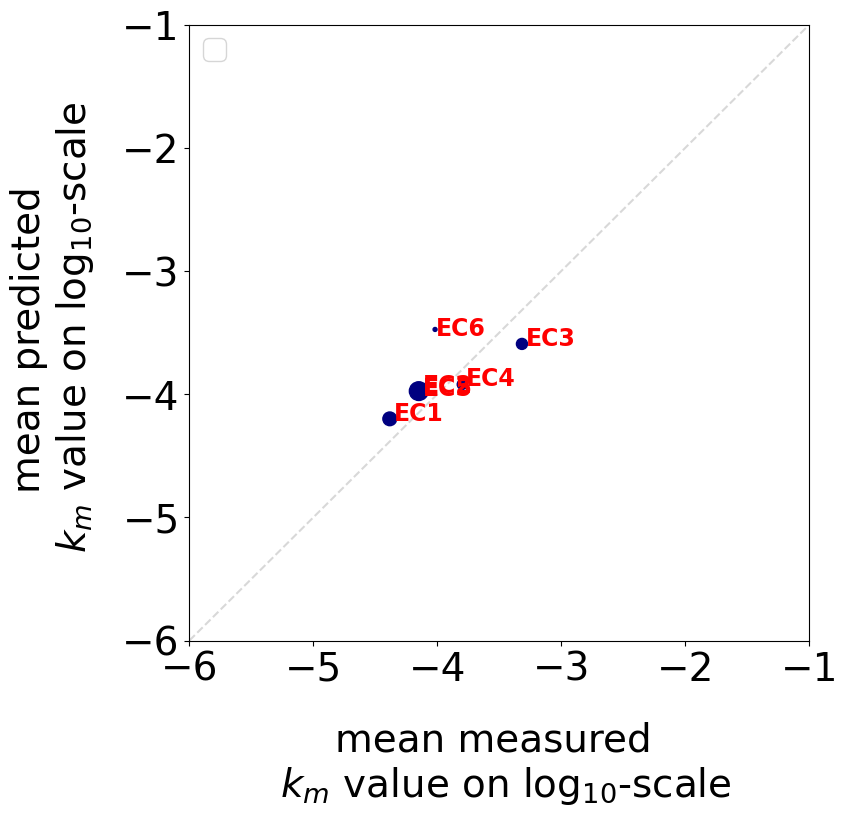

In [54]:
fig, ax = plt.subplots(figsize= (8,8))
plt.rcParams.update({'font.size': 28})

classes = [str(i) for i in range(1,7)]

for i in range(len(EC_km)):
    
    circle = plt.Circle((np.mean(EC_km[i]), np.mean(EC_km_pred[i]) ),
                        np.sqrt(len(EC_km_pred[i]))/300, color='navy', fill = True)
    ax.add_artist(circle)
    if i ==5:
        ax.annotate("EC"+ str(i+1), (np.mean(EC_km[i])+0.01, np.mean(EC_km_pred[i])-0.05), fontsize=17, c='red', weight = "bold")
    else:
        ax.annotate("EC"+ str(i+1), (np.mean(EC_km[i])+0.03, np.mean(EC_km_pred[i])-0.01), fontsize=17, c='red', weight = "bold")
    

# ticks2 = [0.2, 0.6,1,1.4,1.8]
# labs = ticks2
# ax.set_xticks(ticks2)
# ax.set_xticklabels(labs,  y= -0.03, fontsize=26)
# ax.tick_params(axis='x', length=0, rotation = 0)

# ax.set_yticks(ticks2)
# ax.set_yticklabels(labs,  y= -0.03, fontsize=26)
# ax.tick_params(axis='y', length=0, rotation = 0)

plt.ylim((-6,-1))
plt.xlim((-6, -1))
plt.legend(loc = "upper left", fontsize=20)
plt.xlabel('mean measured \n $k_{m}$ value on $\log_{10}$-scale')
plt.ylabel('mean predicted \n $k_{m}$ value on $\log_{10}$-scale')
ax.yaxis.set_label_coords(-0.15, 0.5)
ax.xaxis.set_label_coords(0.5,-0.13)
plt.axline((1, 1), slope=1, c='grey', alpha = 0.3, linestyle='dashed')
plt.savefig(join("..", "..", "data", "EC_classes_mean_km.png"))
plt.show()

In [47]:
import scipy

train_fps = [np.array(list(data_combined["MACCS FP"][ind])).reshape(1,-1) for ind in data_combined.index]
test_fps = [np.array(list(data_val["MACCS FP"][ind])).reshape(1,-1) for ind in data_val.index]

max_sim = []

for fp in test_fps:
    jaccard_sim = np.array([1 - scipy.spatial.distance.cdist(fp,train_fp, metric='jaccard')[0][0] for train_fp in train_fps])
    max_sim.append(np.max(jaccard_sim))
    
data_val["substrate_sim"] = max_sim

data_val["substrate_sim"]= (data_val["substrate_sim"] - np.min(data_val["substrate_sim"]))
data_val["substrate_sim"] = data_val["substrate_sim"]/np.max(data_val["substrate_sim"])

In [49]:
data_val["global_sim"] = (data_val["max_identity"]/100)*data_val["substrate_sim"]

In [50]:
data_val.describe()

,Type,log10_Km,Estimate Km,max_identity,substrate_sim,global_sim
count,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000,1193.000000
mean,1.193630,-4.032997,-3.955143,47.457142,0.824819,0.400482
std,0.395308,0.892771,0.455931,18.275898,0.262642,0.224282
min,1.000000,-5.943095,-5.240119,18.518519,0.000000,0.000000
25%,1.000000,-4.677781,-4.244473,35.080645,0.712821,0.249419
50%,1.000000,-4.130768,-3.942134,39.498433,1.000000,0.352827
75%,1.000000,-3.431798,-3.632830,57.509158,1.000000,0.516598
max,2.000000,-1.663540,-2.713321,100.000000,1.000000,1.000000


0.0 - 0.4 -183.10090646461254 0.09651503349360517 0.0022148675253088265 800
0.4 - 0.8 -78.93025850499711 0.5102101053876755 0.0024603664785932647 276
0.8 - 1 -82.34140917328425 0.2657778865438669 0.001955589791440929 117


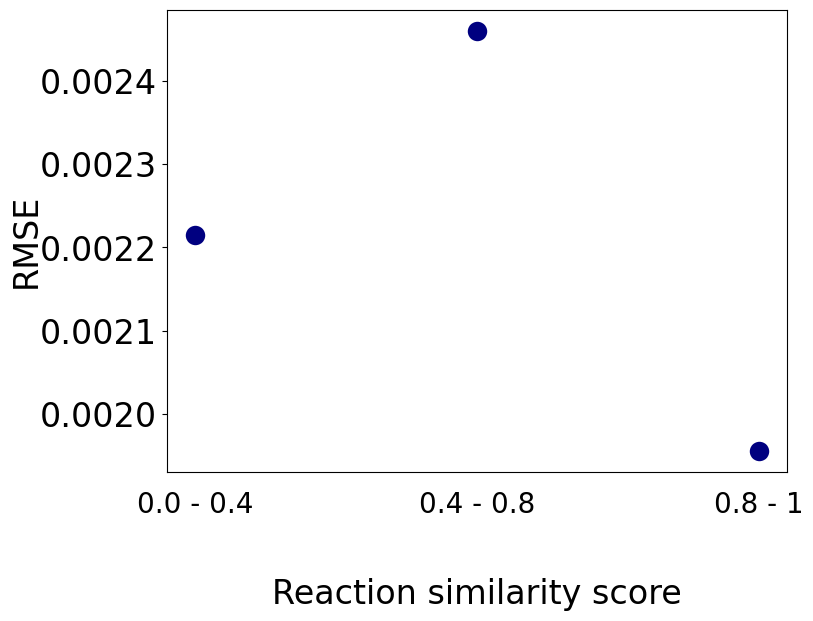

In [55]:
import matplotlib.pyplot as plt
import math
import scipy as sci
help_df = data_val

sim_bins_lb = [0.0, 0.4, 0.8]
sim_bins_ub = [0.4, 0.8, 1]
r2_scores, n_points, pearson_r, rmse = [], [], [], []
for i in range(len(sim_bins_lb)):
    help_df2 = help_df.loc[help_df["global_sim"] <= sim_bins_ub[i]].loc[help_df["global_sim"] >= sim_bins_lb[i]]
    pred = np.array([10**x for x in help_df2["log10_Km"]])
    true = np.array([10**x for x in help_df2["Estimate Km"]])
    r2_scores.append(sk.r2_score(true, pred))
    pearson_r.append(sci.stats.pearsonr(true, pred)[0])
    rmse.append(math.sqrt(np.mean(abs(true - pred)**2)))
    n_points.append(len(pred))
    print("%s - %s" % (sim_bins_lb[i], sim_bins_ub[i]), r2_scores[-1], pearson_r[-1], rmse[-1], len(pred))
    

plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(figsize= (8,6))

for i in range(len(sim_bins_lb)):    
    plt.scatter(i, rmse[i], c='navy', marker="o", linewidths= 8)
    ax.annotate(n_points[i], (i-0.08, rmse[i]+0.05), fontsize=17, c= "black", weight = "bold")

    
plt.xlabel('Reaction similarity score')
plt.ylabel('RMSE')
ax.yaxis.set_label_coords(-0.2, 0.5)
ax.xaxis.set_label_coords(0.5,-0.23)

ticks2 = np.array(range(len(sim_bins_lb)))
labs = ["%s - %s" % (sim_bins_lb[i], sim_bins_ub[i]) for i in range(len(sim_bins_lb))]
ax.set_xticks(ticks2)
ax.set_xticklabels(labs,  y= -0.03, fontsize=20)
ax.tick_params(axis='x', length=0, rotation = 0)

# plt.ylim((0.5,2))
#plt.xlim((-0.5, 3.2))

# plt.plot([-0.49, 4], [0,0], color='grey', linestyle='dashed')
#plt.savefig(join("..","..", "data", "figures", "Reaction_Similarity_Score.eps"))
plt.show()

In [61]:
filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
filtered_df

,Reaction ID,Sequence ID,Temperature,pH,Type,Main substrate,Km_values,Uniprot IDs,ECs,Substrates,Products,ESM2,Sequence,difference_fp,structural_fp,log10_Km
46,Reaction_513,Sequence_525,33.0,8.3,1,0000000000000000000000000000000000000000000000...,[0.00092628],[Q9LE06],[2.6.1.88],L-Methionine;2-Oxoglutarate;,4-Methylthio-2-oxobutanoate;L-Glutamate;,"[0.010767821, -0.016377859, -0.05220723, 0.002...",MAPSAQPLPVSVSDEKYANVKWEELAFKFVRTDYMYVAKCNHGESF...,"[0.0, 0.0, 0.0, 0.0, -20.0, 0.0, 0.0, 0.0, 0.0...",1000000000000000000000000000000001000001001000...,-3.033258
96,Reaction_515,Sequence_525,33.0,8.3,1,0000000000000000000000000000000000000000000000...,[4.52e-05],[Q9LE06],[2.6.1.88],4-Methylthio-2-oxobutanoate;L-Glutamate;,L-Methionine;2-Oxoglutarate;,"[0.010767821, -0.016377859, -0.05220723, 0.002...",MAPSAQPLPVSVSDEKYANVKWEELAFKFVRTDYMYVAKCNHGESF...,"[0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0,...",1000000000000000000000000000000001000001001000...,-4.344862


## 2. Training a model with enzyme and reaction information (ESM-2/diff_fp) + Temperature + pH :

#### (a) Creating input matrices:

In [6]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [ ]:
def cross_validation_mse_gradient_boosting(param):
    num_round = param["num_rounds"]
    del param["num_rounds"]
    param["max_depth"] = int(np.round(param["max_depth"]))
    # param["device"] = "cuda"
    param["tree_method"] = "hist"
    param["sampling_method"] = "gradient_based"
    
    MSE = []
    R2 = []
    for i in range(5):
        train_index, test_index  = train_indices[i], test_indices[i]
        dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
        dvalid = xgb.DMatrix(train_X[test_index])
        bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
        y_valid_pred = bst.predict(dvalid)
        MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
        R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
    return(-np.mean(R2))


from hyperopt import fmin, tpe, rand, hp, Trials

space_gradient_boosting = {
    "learning_rate": hp.choice("learning_rate", np.linspace(0.01, 0.1, 10)),
    "max_depth": hp.choice("max_depth", np.linspace(3,10,7)),
    #"subsample": hp.quniform("subsample", 0.5, 1),
    "reg_lambda": hp.choice("reg_lambda", np.linspace(0, 1, 10)),
    "reg_alpha": hp.choice("reg_alpha", np.linspace(0, 1, 10)),
    "max_delta_step": hp.choice("max_delta_step", np.linspace(1, 5, 5)),
    "min_child_weight": hp.choice("min_child_weight", np.linspace(1, 6, 6)),
    "num_rounds":  hp.choice("num_rounds", np.linspace(50, 200, 4))}


trials = Trials()
best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
            algo=rand.suggest, max_evals = 10, trials=trials)

In [7]:
print(best)

{'learning_rate': 0.09520483912085438, 'max_delta_step': 3.2085882579611376, 'max_depth': 6.285643927414824, 'min_child_weight': 4.844113063639365, 'num_rounds': 161.0710217538525, 'reg_alpha': 0.04313635920493297, 'reg_lambda': 0.863571899447082}


{'learning_rate': 0.09520483912085438, 'max_delta_step': 3.2085882579611376, 'max_depth': 6.285643927414824, 'min_child_weight': 4.844113063639365, 'num_rounds': 161.0710217538525, 'reg_alpha': 0.04313635920493297, 'reg_lambda': 0.863571899447082}

#### (c) Training and validating model:

In [7]:
param = {"random_state": 42, 
         'learning_rate': 0.09520483912085438, 
         'max_delta_step': 3.2085882579611376, 
         'max_depth': 6.285643927414824, 
         'min_child_weight': 4.844113063639365, 
         'num_rounds': 161.0710217538525, 
         'reg_alpha': 0.04313635920493297, 
         'reg_lambda': 0.863571899447082}

num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [16]:
import random

R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred])))
    MedAE.append(np.median(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred])))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(R2))

[0.5004989126558848, 0.2642281433065132, 0.44627564547233695, 0.3523961966968977, 0.29194434902266675]
[0.0015808818256603122, 0.001767682718739059, 0.0018409569308640542, 0.0025611352120127246, 0.001669976292140052]
[0.0828190864216034, 0.037060775730762496, 0.08249603448669252, -0.008673948832314204, 0.021682485322662925]
[0.00047039840029274873, 0.00029191254230979686, 0.00046880988490891556, 0.0007617342890363818, 0.0004198058107003867]
[4.729086249828126e-06, -1.552401625159497e-05, 5.059385738282466e-06, 7.844324347381386e-06, -1.2984040632659323e-06]


In [17]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate Km"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", "y_test_pred_xgboost_ESM1b_ts_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_ESM1b_ts_diff_fp.npy"), test_Y)

0.223 0.002070037 -0.006 0.0005670711 7.6721e-05


In [ ]:
y_test_pred_esm1b_ts_drfp = y_test_pred

#### (d) Training model with test and train data for production mode:

In [ ]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [37]:
param = {"random_state": 42, 
         'learning_rate': 0.09520483912085438, 
         'max_delta_step': 3.2085882579611376, 
         'max_depth': 6.285643927414824, 
         'min_child_weight': 4.844113063639365, 
         'num_rounds': 161.0710217538525, 
         'reg_alpha': 0.04313635920493297, 
         'reg_lambda': 0.863571899447082}

num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.8191781274839552, 1.0025941835784315e-31) 0.0008252442918153328 0.595390057711825


## 3. Training a model with enzyme, main substrate (MACCS fp) and reaction information (ESM-2/diff_fp) + Temperature + pH :

#### (a) Creating input matrices:

In [18]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array([list(s) for s in data_train['MACCS FP']]), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array([list(s) for s in data_test['MACCS FP']]), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [ ]:
def cross_validation_mse_gradient_boosting(param):
    num_round = param["num_rounds"]
    del param["num_rounds"]
    param["max_depth"] = int(np.round(param["max_depth"]))
    # param["device"] = "cuda"
    param["tree_method"] = "hist"
    param["sampling_method"] = "gradient_based"
    
    MSE = []
    R2 = []
    for i in range(5):
        train_index, test_index  = train_indices[i], test_indices[i]
        dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
        dvalid = xgb.DMatrix(train_X[test_index])
        bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
        y_valid_pred = bst.predict(dvalid)
        MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
        R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
    return(-np.mean(R2))


from hyperopt import fmin, tpe, rand, hp, Trials

space_gradient_boosting = {
    "learning_rate": hp.choice("learning_rate", np.linspace(0.01, 0.1, 10)),
    "max_depth": hp.choice("max_depth", np.linspace(3,10,7)),
    #"subsample": hp.quniform("subsample", 0.5, 1),
    "reg_lambda": hp.choice("reg_lambda", np.linspace(0, 1, 10)),
    "reg_alpha": hp.choice("reg_alpha", np.linspace(0, 1, 10)),
    "max_delta_step": hp.choice("max_delta_step", np.linspace(1, 5, 5)),
    "min_child_weight": hp.choice("min_child_weight", np.linspace(1, 6, 6)),
    "num_rounds":  hp.choice("num_rounds", np.linspace(50, 200, 4))}


trials = Trials()
best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
            algo=rand.suggest, max_evals = 10, trials=trials)

In [9]:
print(best)

{'learning_rate': 0.09123901820647302, 'max_delta_step': 3.293469875542088, 'max_depth': 4.642008853753186, 'min_child_weight': 5.26237083558016, 'num_rounds': 95.44623761677761, 'reg_alpha': 0.7752660204489337, 'reg_lambda': 0.8258449480809661}


{'learning_rate': 0.09123901820647302, 'max_delta_step': 3.293469875542088, 'max_depth': 4.642008853753186, 'min_child_weight': 5.26237083558016, 'num_rounds': 95.44623761677761, 'reg_alpha': 0.7752660204489337, 'reg_lambda': 0.8258449480809661}

#### (c) Training and validating model:

In [19]:
param = {"random_state": 42, 
         'learning_rate': 0.09123901820647302, 
         'max_delta_step': 3.293469875542088, 
         'max_depth': 4.642008853753186, 
         'min_child_weight': 5.26237083558016, 
         'num_rounds': 95.44623761677761, 
         'reg_alpha': 0.7752660204489337, 
         'reg_lambda': 0.8258449480809661}

num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [20]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred])))
    MedAE.append(np.median(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred])))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(R2))

[0.5782638174309085, 0.31536378108397056, 0.4239649388833847, 0.3811688824928939, 0.3195929770173968]
[0.0015518756593776188, 0.0017477478928113518, 0.00188573092926473, 0.0025752185598860258, 0.0016650106646491725]
[0.11616735601627326, 0.05865716878740268, 0.03732400620178278, -0.019797581162449562, 0.027491834670146487]
[0.00046394599158358895, 0.00035071033827085583, 0.0005090430887877511, 0.0007936075367073008, 0.000431889833420476]
[8.915169226702115e-07, -8.796847898615276e-06, 6.7304073288717615e-06, 1.1895404349939769e-05, -1.8713330347011054e-06]


In [21]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate Km"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", "y_test_pred_xgboost_ESM1b_ts_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_ESM1b_ts_diff_fp.npy"), test_Y)

0.242 0.0020694609 -0.006 0.0005684627 7.30839e-05


In [ ]:
y_test_pred_esm1b_ts_drfp = y_test_pred

#### (d) Training model with test and train data for production mode:

In [ ]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array([list(s) for s in data_train['MACCS FP']]), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array([list(s) for s in data_test['MACCS FP']]), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [ ]:
param = {"random_state": 42, 
         'learning_rate': 0.09123901820647302, 
         'max_delta_step': 3.293469875542088, 
         'max_depth': 4.642008853753186, 
         'min_child_weight': 5.26237083558016, 
         'num_rounds': 95.44623761677761, 
         'reg_alpha': 0.7752660204489337, 
         'reg_lambda': 0.8258449480809661}

num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.7213782919502226, 2.3421181876329e-21) 1.6940701870028284e-06 -0.2492829413353581


## 4. Training a model with enzyme information (ESM-2) + Temperature + pH:

#### (a) Creating input matrices:

In [ ]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [ ]:
def cross_validation_mse_gradient_boosting(param):
    num_round = param["num_rounds"]
    del param["num_rounds"]
    param["max_depth"] = int(np.round(param["max_depth"]))
    # param["device"] = "cuda"
    param["tree_method"] = "hist"
    param["sampling_method"] = "gradient_based"
    
    MSE = []
    R2 = []
    for i in range(5):
        train_index, test_index  = train_indices[i], test_indices[i]
        dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
        dvalid = xgb.DMatrix(train_X[test_index])
        bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
        y_valid_pred = bst.predict(dvalid)
        MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
        R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
    return(-np.mean(R2))


from hyperopt import fmin, tpe, rand, hp, Trials

space_gradient_boosting = {
    "learning_rate": hp.choice("learning_rate", np.linspace(0.01, 0.1, 10)),
    "max_depth": hp.choice("max_depth", np.linspace(3,10,7)),
    #"subsample": hp.quniform("subsample", 0.5, 1),
    "reg_lambda": hp.choice("reg_lambda", np.linspace(0, 1, 10)),
    "reg_alpha": hp.choice("reg_alpha", np.linspace(0, 1, 10)),
    "max_delta_step": hp.choice("max_delta_step", np.linspace(1, 5, 5)),
    "min_child_weight": hp.choice("min_child_weight", np.linspace(1, 6, 6)),
    "num_rounds":  hp.choice("num_rounds", np.linspace(50, 200, 4))}


trials = Trials()
best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
            algo=rand.suggest, max_evals = 10, trials=trials)

In [ ]:
print(best)

{'learning_rate': 0.055115325102336195, 'max_delta_step': 4.3782574746699785, 'max_depth': 8.234288018350421, 'min_child_weight': 3.197892054267437, 'num_rounds': 169.11296626727352, 'reg_alpha': 0.45172341759748236, 'reg_lambda': 0.7434118607991583}


{'learning_rate': 0.055115325102336195, 'max_delta_step': 4.3782574746699785, 'max_depth': 8.234288018350421, 'min_child_weight': 3.197892054267437, 'num_rounds': 169.11296626727352, 'reg_alpha': 0.45172341759748236, 'reg_lambda': 0.7434118607991583}

#### (c) Training and validating model:

In [ ]:
param = {"random_state": 42, 
         'learning_rate': 0.055115325102336195, 
         'max_delta_step': 4.3782574746699785, 
         'max_depth': 8.234288018350421, 
         'min_child_weight': 3.197892054267437, 
         'num_rounds': 169.11296626727352, 
         'reg_alpha': 0.45172341759748236, 
         'reg_lambda': 0.7434118607991583}

num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [ ]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred])))
    MedAE.append(np.median(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred])))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(R2))

KeyboardInterrupt: 

In [ ]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate Km"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", "y_test_pred_xgboost_ESM1b_ts_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_ESM1b_ts_diff_fp.npy"), test_Y)

0.2 0.0013249325 -0.04 0.0005013069 9.69164e-05


In [ ]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate Km"] = [10**x for x in data_test["Estimate Km"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

,Reaction ID,Sequence ID,Temperature,pH,Type,Main substrate,Km_values,Uniprot IDs,ECs,Substrates,Products,ESM2,Sequence,difference_fp,structural_fp,log10_Km,Estimate Km
46,Reaction_513,Sequence_525,33.0,8.3,1,0000000000000000000000000000000000000000000000...,[0.00092628],[Q9LE06],[2.6.1.88],L-Methionine;2-Oxoglutarate;,4-Methylthio-2-oxobutanoate;L-Glutamate;,"[0.010767821, -0.016377859, -0.05220723, 0.002...",MAPSAQPLPVSVSDEKYANVKWEELAFKFVRTDYMYVAKCNHGESF...,"[0.0, 0.0, 0.0, 0.0, -20.0, 0.0, 0.0, 0.0, 0.0...",1000000000000000000000000000000001000001001000...,-3.033258,0.000535
96,Reaction_515,Sequence_525,33.0,8.3,1,0000000000000000000000000000000000000000000000...,[4.52e-05],[Q9LE06],[2.6.1.88],4-Methylthio-2-oxobutanoate;L-Glutamate;,L-Methionine;2-Oxoglutarate;,"[0.010767821, -0.016377859, -0.05220723, 0.002...",MAPSAQPLPVSVSDEKYANVKWEELAFKFVRTDYMYVAKCNHGESF...,"[0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0,...",1000000000000000000000000000000001000001001000...,-4.344862,0.000085


#### (d) Training model with test and train data for production mode:

In [ ]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [ ]:
param = {"random_state": 42, 
         'learning_rate': 0.055115325102336195, 
         'max_delta_step': 4.3782574746699785, 
         'max_depth': 8.234288018350421, 
         'min_child_weight': 3.197892054267437, 
         'num_rounds': 169.11296626727352, 
         'reg_alpha': 0.45172341759748236, 
         'reg_lambda': 0.7434118607991583}

num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.8615311803627979, 2.592247953387984e-38) 0.0007210631060349314 0.691099904743456


In [ ]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

1280
167


{'f0': 14.0,
 'f1': 19.0,
 'f2': 33.0,
 'f3': 16.0,
 'f4': 31.0,
 'f5': 16.0,
 'f6': 18.0,
 'f7': 21.0,
 'f8': 13.0,
 'f9': 7.0,
 'f10': 12.0,
 'f11': 14.0,
 'f12': 22.0,
 'f13': 16.0,
 'f14': 5.0,
 'f15': 6.0,
 'f16': 11.0,
 'f17': 24.0,
 'f18': 17.0,
 'f19': 6.0,
 'f20': 11.0,
 'f21': 9.0,
 'f22': 9.0,
 'f23': 5.0,
 'f24': 17.0,
 'f25': 3.0,
 'f26': 11.0,
 'f27': 7.0,
 'f28': 9.0,
 'f29': 11.0,
 'f30': 7.0,
 'f31': 6.0,
 'f32': 8.0,
 'f33': 8.0,
 'f34': 7.0,
 'f35': 12.0,
 'f36': 6.0,
 'f37': 8.0,
 'f38': 8.0,
 'f39': 6.0,
 'f40': 10.0,
 'f41': 13.0,
 'f42': 16.0,
 'f43': 5.0,
 'f44': 6.0,
 'f45': 8.0,
 'f46': 27.0,
 'f47': 4.0,
 'f48': 8.0,
 'f49': 6.0,
 'f50': 7.0,
 'f51': 7.0,
 'f52': 8.0,
 'f53': 14.0,
 'f54': 2.0,
 'f55': 7.0,
 'f56': 8.0,
 'f57': 2.0,
 'f58': 3.0,
 'f59': 1.0,
 'f60': 5.0,
 'f61': 10.0,
 'f62': 10.0,
 'f63': 1.0,
 'f64': 4.0,
 'f65': 9.0,
 'f66': 1.0,
 'f67': 20.0,
 'f68': 8.0,
 'f69': 1.0,
 'f70': 4.0,
 'f71': 13.0,
 'f72': 4.0,
 'f73': 4.0,
 'f74': 4.0,
 'f75

#### (e) Validating model:

In [ ]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_Km"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate Km"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE)

## 5. Training a model with main substrate information (MACCS) + Temperature + pH:

#### (a) Creating input matrices:

In [ ]:
train_X = np.array([list(s) for s in data_train['MACCS FP']])
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array([list(s) for s in data_test['MACCS FP']])
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [ ]:
def cross_validation_mse_gradient_boosting(param):
    num_round = param["num_rounds"]
    del param["num_rounds"]
    param["max_depth"] = int(np.round(param["max_depth"]))
    # param["device"] = "cuda"
    param["tree_method"] = "hist"
    param["sampling_method"] = "gradient_based"
    
    MSE = []
    R2 = []
    for i in range(5):
        train_index, test_index  = train_indices[i], test_indices[i]
        dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
        dvalid = xgb.DMatrix(train_X[test_index])
        bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
        y_valid_pred = bst.predict(dvalid)
        MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
        R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
    return(-np.mean(R2))


from hyperopt import fmin, tpe, rand, hp, Trials

space_gradient_boosting = {
    "learning_rate": hp.choice("learning_rate", np.linspace(0.01, 0.1, 10)),
    "max_depth": hp.choice("max_depth", np.linspace(3,10,7)),
    #"subsample": hp.quniform("subsample", 0.5, 1),
    "reg_lambda": hp.choice("reg_lambda", np.linspace(0, 1, 10)),
    "reg_alpha": hp.choice("reg_alpha", np.linspace(0, 1, 10)),
    "max_delta_step": hp.choice("max_delta_step", np.linspace(1, 5, 5)),
    "min_child_weight": hp.choice("min_child_weight", np.linspace(1, 6, 6)),
    "num_rounds":  hp.choice("num_rounds", np.linspace(50, 200, 4))}


trials = Trials()
best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
            algo=rand.suggest, max_evals = 10, trials=trials)

In [ ]:
print(best)

{'learning_rate': 0.055115325102336195, 'max_delta_step': 4.3782574746699785, 'max_depth': 8.234288018350421, 'min_child_weight': 3.197892054267437, 'num_rounds': 169.11296626727352, 'reg_alpha': 0.45172341759748236, 'reg_lambda': 0.7434118607991583}


{'learning_rate': 0.055115325102336195, 'max_delta_step': 4.3782574746699785, 'max_depth': 8.234288018350421, 'min_child_weight': 3.197892054267437, 'num_rounds': 169.11296626727352, 'reg_alpha': 0.45172341759748236, 'reg_lambda': 0.7434118607991583}

#### (c) Training and validating model:

In [ ]:
param = {"random_state": 42, 
         'learning_rate': 0.055115325102336195, 
         'max_delta_step': 4.3782574746699785, 
         'max_depth': 8.234288018350421, 
         'min_child_weight': 3.197892054267437, 
         'num_rounds': 169.11296626727352, 
         'reg_alpha': 0.45172341759748236, 
         'reg_lambda': 0.7434118607991583}

num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [ ]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred])))
    MedAE.append(np.median(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred])))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(R2))

KeyboardInterrupt: 

In [ ]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate Km"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", "y_test_pred_xgboost_ESM1b_ts_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_ESM1b_ts_diff_fp.npy"), test_Y)

0.2 0.0013249325 -0.04 0.0005013069 9.69164e-05


In [ ]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate Km"] = [10**x for x in data_test["Estimate Km"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

,Reaction ID,Sequence ID,Temperature,pH,Type,Main substrate,Km_values,Uniprot IDs,ECs,Substrates,Products,ESM2,Sequence,difference_fp,structural_fp,log10_Km,Estimate Km
46,Reaction_513,Sequence_525,33.0,8.3,1,0000000000000000000000000000000000000000000000...,[0.00092628],[Q9LE06],[2.6.1.88],L-Methionine;2-Oxoglutarate;,4-Methylthio-2-oxobutanoate;L-Glutamate;,"[0.010767821, -0.016377859, -0.05220723, 0.002...",MAPSAQPLPVSVSDEKYANVKWEELAFKFVRTDYMYVAKCNHGESF...,"[0.0, 0.0, 0.0, 0.0, -20.0, 0.0, 0.0, 0.0, 0.0...",1000000000000000000000000000000001000001001000...,-3.033258,0.000535
96,Reaction_515,Sequence_525,33.0,8.3,1,0000000000000000000000000000000000000000000000...,[4.52e-05],[Q9LE06],[2.6.1.88],4-Methylthio-2-oxobutanoate;L-Glutamate;,L-Methionine;2-Oxoglutarate;,"[0.010767821, -0.016377859, -0.05220723, 0.002...",MAPSAQPLPVSVSDEKYANVKWEELAFKFVRTDYMYVAKCNHGESF...,"[0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0,...",1000000000000000000000000000000001000001001000...,-4.344862,0.000085


#### (d) Training model with test and train data for production mode:

In [ ]:
train_X = np.array([list(s) for s in data_train['MACCS FP']])
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array([list(s) for s in data_test['MACCS FP']])
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [ ]:
param = {"random_state": 42, 
         'learning_rate': 0.055115325102336195, 
         'max_delta_step': 4.3782574746699785, 
         'max_depth': 8.234288018350421, 
         'min_child_weight': 3.197892054267437, 
         'num_rounds': 169.11296626727352, 
         'reg_alpha': 0.45172341759748236, 
         'reg_lambda': 0.7434118607991583}

num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.8615311803627979, 2.592247953387984e-38) 0.0007210631060349314 0.691099904743456


In [ ]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

1280
167


{'f0': 14.0,
 'f1': 19.0,
 'f2': 33.0,
 'f3': 16.0,
 'f4': 31.0,
 'f5': 16.0,
 'f6': 18.0,
 'f7': 21.0,
 'f8': 13.0,
 'f9': 7.0,
 'f10': 12.0,
 'f11': 14.0,
 'f12': 22.0,
 'f13': 16.0,
 'f14': 5.0,
 'f15': 6.0,
 'f16': 11.0,
 'f17': 24.0,
 'f18': 17.0,
 'f19': 6.0,
 'f20': 11.0,
 'f21': 9.0,
 'f22': 9.0,
 'f23': 5.0,
 'f24': 17.0,
 'f25': 3.0,
 'f26': 11.0,
 'f27': 7.0,
 'f28': 9.0,
 'f29': 11.0,
 'f30': 7.0,
 'f31': 6.0,
 'f32': 8.0,
 'f33': 8.0,
 'f34': 7.0,
 'f35': 12.0,
 'f36': 6.0,
 'f37': 8.0,
 'f38': 8.0,
 'f39': 6.0,
 'f40': 10.0,
 'f41': 13.0,
 'f42': 16.0,
 'f43': 5.0,
 'f44': 6.0,
 'f45': 8.0,
 'f46': 27.0,
 'f47': 4.0,
 'f48': 8.0,
 'f49': 6.0,
 'f50': 7.0,
 'f51': 7.0,
 'f52': 8.0,
 'f53': 14.0,
 'f54': 2.0,
 'f55': 7.0,
 'f56': 8.0,
 'f57': 2.0,
 'f58': 3.0,
 'f59': 1.0,
 'f60': 5.0,
 'f61': 10.0,
 'f62': 10.0,
 'f63': 1.0,
 'f64': 4.0,
 'f65': 9.0,
 'f66': 1.0,
 'f67': 20.0,
 'f68': 8.0,
 'f69': 1.0,
 'f70': 4.0,
 'f71': 13.0,
 'f72': 4.0,
 'f73': 4.0,
 'f74': 4.0,
 'f75

#### (e) Validating model:

In [ ]:
val_X = np.array([list(s) for s in data_val['MACCS FP']])
val_X = np.concatenate([val_X, np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_Km"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate Km"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE)

## 6. Training a model with reaction information (diff-fp) + Temperature + pH:

#### (a) Creating input matrices:

In [ ]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [ ]:
def cross_validation_mse_gradient_boosting(param):
    num_round = param["num_rounds"]
    del param["num_rounds"]
    param["max_depth"] = int(np.round(param["max_depth"]))
    # param["device"] = "cuda"
    param["tree_method"] = "hist"
    param["sampling_method"] = "gradient_based"
    
    MSE = []
    R2 = []
    for i in range(5):
        train_index, test_index  = train_indices[i], test_indices[i]
        dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
        dvalid = xgb.DMatrix(train_X[test_index])
        bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
        y_valid_pred = bst.predict(dvalid)
        MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
        R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
    return(-np.mean(R2))


from hyperopt import fmin, tpe, rand, hp, Trials

space_gradient_boosting = {
    "learning_rate": hp.choice("learning_rate", np.linspace(0.01, 0.1, 10)),
    "max_depth": hp.choice("max_depth", np.linspace(3,10,7)),
    #"subsample": hp.quniform("subsample", 0.5, 1),
    "reg_lambda": hp.choice("reg_lambda", np.linspace(0, 1, 10)),
    "reg_alpha": hp.choice("reg_alpha", np.linspace(0, 1, 10)),
    "max_delta_step": hp.choice("max_delta_step", np.linspace(1, 5, 5)),
    "min_child_weight": hp.choice("min_child_weight", np.linspace(1, 6, 6)),
    "num_rounds":  hp.choice("num_rounds", np.linspace(50, 200, 4))}


trials = Trials()
best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
            algo=rand.suggest, max_evals = 10, trials=trials)

In [ ]:
print(best)

{'learning_rate': 0.055115325102336195, 'max_delta_step': 4.3782574746699785, 'max_depth': 8.234288018350421, 'min_child_weight': 3.197892054267437, 'num_rounds': 169.11296626727352, 'reg_alpha': 0.45172341759748236, 'reg_lambda': 0.7434118607991583}


{'learning_rate': 0.055115325102336195, 'max_delta_step': 4.3782574746699785, 'max_depth': 8.234288018350421, 'min_child_weight': 3.197892054267437, 'num_rounds': 169.11296626727352, 'reg_alpha': 0.45172341759748236, 'reg_lambda': 0.7434118607991583}

#### (c) Training and validating model:

In [ ]:
param = {"random_state": 42, 
         'learning_rate': 0.055115325102336195, 
         'max_delta_step': 4.3782574746699785, 
         'max_depth': 8.234288018350421, 
         'min_child_weight': 3.197892054267437, 
         'num_rounds': 169.11296626727352, 
         'reg_alpha': 0.45172341759748236, 
         'reg_lambda': 0.7434118607991583}

num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [ ]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred])))
    MedAE.append(np.median(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred])))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(R2))

KeyboardInterrupt: 

In [ ]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate Km"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", "y_test_pred_xgboost_ESM1b_ts_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_ESM1b_ts_diff_fp.npy"), test_Y)

0.2 0.0013249325 -0.04 0.0005013069 9.69164e-05


In [ ]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate Km"] = [10**x for x in data_test["Estimate Km"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

,Reaction ID,Sequence ID,Temperature,pH,Type,Main substrate,Km_values,Uniprot IDs,ECs,Substrates,Products,ESM2,Sequence,difference_fp,structural_fp,log10_Km,Estimate Km
46,Reaction_513,Sequence_525,33.0,8.3,1,0000000000000000000000000000000000000000000000...,[0.00092628],[Q9LE06],[2.6.1.88],L-Methionine;2-Oxoglutarate;,4-Methylthio-2-oxobutanoate;L-Glutamate;,"[0.010767821, -0.016377859, -0.05220723, 0.002...",MAPSAQPLPVSVSDEKYANVKWEELAFKFVRTDYMYVAKCNHGESF...,"[0.0, 0.0, 0.0, 0.0, -20.0, 0.0, 0.0, 0.0, 0.0...",1000000000000000000000000000000001000001001000...,-3.033258,0.000535
96,Reaction_515,Sequence_525,33.0,8.3,1,0000000000000000000000000000000000000000000000...,[4.52e-05],[Q9LE06],[2.6.1.88],4-Methylthio-2-oxobutanoate;L-Glutamate;,L-Methionine;2-Oxoglutarate;,"[0.010767821, -0.016377859, -0.05220723, 0.002...",MAPSAQPLPVSVSDEKYANVKWEELAFKFVRTDYMYVAKCNHGESF...,"[0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0,...",1000000000000000000000000000000001000001001000...,-4.344862,0.000085


#### (d) Training model with test and train data for production mode:

In [ ]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array([list(s) for s in data_train['MACCS FP']]), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array([list(s) for s in data_test['MACCS FP']]), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [ ]:
param = {"random_state": 42, 
         'learning_rate': 0.055115325102336195, 
         'max_delta_step': 4.3782574746699785, 
         'max_depth': 8.234288018350421, 
         'min_child_weight': 3.197892054267437, 
         'num_rounds': 169.11296626727352, 
         'reg_alpha': 0.45172341759748236, 
         'reg_lambda': 0.7434118607991583}

num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.8615311803627979, 2.592247953387984e-38) 0.0007210631060349314 0.691099904743456


In [ ]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

1280
167


{'f0': 14.0,
 'f1': 19.0,
 'f2': 33.0,
 'f3': 16.0,
 'f4': 31.0,
 'f5': 16.0,
 'f6': 18.0,
 'f7': 21.0,
 'f8': 13.0,
 'f9': 7.0,
 'f10': 12.0,
 'f11': 14.0,
 'f12': 22.0,
 'f13': 16.0,
 'f14': 5.0,
 'f15': 6.0,
 'f16': 11.0,
 'f17': 24.0,
 'f18': 17.0,
 'f19': 6.0,
 'f20': 11.0,
 'f21': 9.0,
 'f22': 9.0,
 'f23': 5.0,
 'f24': 17.0,
 'f25': 3.0,
 'f26': 11.0,
 'f27': 7.0,
 'f28': 9.0,
 'f29': 11.0,
 'f30': 7.0,
 'f31': 6.0,
 'f32': 8.0,
 'f33': 8.0,
 'f34': 7.0,
 'f35': 12.0,
 'f36': 6.0,
 'f37': 8.0,
 'f38': 8.0,
 'f39': 6.0,
 'f40': 10.0,
 'f41': 13.0,
 'f42': 16.0,
 'f43': 5.0,
 'f44': 6.0,
 'f45': 8.0,
 'f46': 27.0,
 'f47': 4.0,
 'f48': 8.0,
 'f49': 6.0,
 'f50': 7.0,
 'f51': 7.0,
 'f52': 8.0,
 'f53': 14.0,
 'f54': 2.0,
 'f55': 7.0,
 'f56': 8.0,
 'f57': 2.0,
 'f58': 3.0,
 'f59': 1.0,
 'f60': 5.0,
 'f61': 10.0,
 'f62': 10.0,
 'f63': 1.0,
 'f64': 4.0,
 'f65': 9.0,
 'f66': 1.0,
 'f67': 20.0,
 'f68': 8.0,
 'f69': 1.0,
 'f70': 4.0,
 'f71': 13.0,
 'f72': 4.0,
 'f73': 4.0,
 'f74': 4.0,
 'f75

#### (e) Validating model:

In [ ]:
val_X = np.array(list(data_val["difference_fp"]))
val_X = np.concatenate([val_X, np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_Km"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate Km"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE)

## 7. Training a model with reaction and main substrate information (diff-fp/MACCS) + Temperature + pH:

#### (a) Creating input matrices:

In [ ]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array([list(s) for s in data_train['MACCS FP']]), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array([list(s) for s in data_test['MACCS FP']]), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [ ]:
def cross_validation_mse_gradient_boosting(param):
    num_round = param["num_rounds"]
    del param["num_rounds"]
    param["max_depth"] = int(np.round(param["max_depth"]))
    # param["device"] = "cuda"
    param["tree_method"] = "hist"
    param["sampling_method"] = "gradient_based"
    
    MSE = []
    R2 = []
    for i in range(5):
        train_index, test_index  = train_indices[i], test_indices[i]
        dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
        dvalid = xgb.DMatrix(train_X[test_index])
        bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
        y_valid_pred = bst.predict(dvalid)
        MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
        R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
    return(-np.mean(R2))


from hyperopt import fmin, tpe, rand, hp, Trials

space_gradient_boosting = {
    "learning_rate": hp.choice("learning_rate", np.linspace(0.01, 0.1, 10)),
    "max_depth": hp.choice("max_depth", np.linspace(3,10,7)),
    #"subsample": hp.quniform("subsample", 0.5, 1),
    "reg_lambda": hp.choice("reg_lambda", np.linspace(0, 1, 10)),
    "reg_alpha": hp.choice("reg_alpha", np.linspace(0, 1, 10)),
    "max_delta_step": hp.choice("max_delta_step", np.linspace(1, 5, 5)),
    "min_child_weight": hp.choice("min_child_weight", np.linspace(1, 6, 6)),
    "num_rounds":  hp.choice("num_rounds", np.linspace(50, 200, 4))}


trials = Trials()
best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
            algo=rand.suggest, max_evals = 10, trials=trials)

In [ ]:
print(best)

{'learning_rate': 0.055115325102336195, 'max_delta_step': 4.3782574746699785, 'max_depth': 8.234288018350421, 'min_child_weight': 3.197892054267437, 'num_rounds': 169.11296626727352, 'reg_alpha': 0.45172341759748236, 'reg_lambda': 0.7434118607991583}


{'learning_rate': 0.055115325102336195, 'max_delta_step': 4.3782574746699785, 'max_depth': 8.234288018350421, 'min_child_weight': 3.197892054267437, 'num_rounds': 169.11296626727352, 'reg_alpha': 0.45172341759748236, 'reg_lambda': 0.7434118607991583}

#### (c) Training and validating model:

In [ ]:
param = {"random_state": 42, 
         'learning_rate': 0.055115325102336195, 
         'max_delta_step': 4.3782574746699785, 
         'max_depth': 8.234288018350421, 
         'min_child_weight': 3.197892054267437, 
         'num_rounds': 169.11296626727352, 
         'reg_alpha': 0.45172341759748236, 
         'reg_lambda': 0.7434118607991583}

num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [ ]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred])))
    MedAE.append(np.median(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred])))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", "Pearson_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", "MSE_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", "R2_CV_xgboost_ESM1b_ts_diff_fp.npy"), np.array(R2))

KeyboardInterrupt: 

In [ ]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate Km"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", "y_test_pred_xgboost_ESM1b_ts_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data",  "y_test_true_xgboost_ESM1b_ts_diff_fp.npy"), test_Y)

0.2 0.0013249325 -0.04 0.0005013069 9.69164e-05


In [ ]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate Km"] = [10**x for x in data_test["Estimate Km"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

,Reaction ID,Sequence ID,Temperature,pH,Type,Main substrate,Km_values,Uniprot IDs,ECs,Substrates,Products,ESM2,Sequence,difference_fp,structural_fp,log10_Km,Estimate Km
46,Reaction_513,Sequence_525,33.0,8.3,1,0000000000000000000000000000000000000000000000...,[0.00092628],[Q9LE06],[2.6.1.88],L-Methionine;2-Oxoglutarate;,4-Methylthio-2-oxobutanoate;L-Glutamate;,"[0.010767821, -0.016377859, -0.05220723, 0.002...",MAPSAQPLPVSVSDEKYANVKWEELAFKFVRTDYMYVAKCNHGESF...,"[0.0, 0.0, 0.0, 0.0, -20.0, 0.0, 0.0, 0.0, 0.0...",1000000000000000000000000000000001000001001000...,-3.033258,0.000535
96,Reaction_515,Sequence_525,33.0,8.3,1,0000000000000000000000000000000000000000000000...,[4.52e-05],[Q9LE06],[2.6.1.88],4-Methylthio-2-oxobutanoate;L-Glutamate;,L-Methionine;2-Oxoglutarate;,"[0.010767821, -0.016377859, -0.05220723, 0.002...",MAPSAQPLPVSVSDEKYANVKWEELAFKFVRTDYMYVAKCNHGESF...,"[0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0,...",1000000000000000000000000000000001000001001000...,-4.344862,0.000085


#### (d) Training model with test and train data for production mode:

In [ ]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array([list(s) for s in data_train['MACCS FP']]), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array([list(s) for s in data_test['MACCS FP']]), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [ ]:
param = {"random_state": 42, 
         'learning_rate': 0.055115325102336195, 
         'max_delta_step': 4.3782574746699785, 
         'max_depth': 8.234288018350421, 
         'min_child_weight': 3.197892054267437, 
         'num_rounds': 169.11296626727352, 
         'reg_alpha': 0.45172341759748236, 
         'reg_lambda': 0.7434118607991583}

num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.8615311803627979, 2.592247953387984e-38) 0.0007210631060349314 0.691099904743456


In [ ]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

1280
167


{'f0': 14.0,
 'f1': 19.0,
 'f2': 33.0,
 'f3': 16.0,
 'f4': 31.0,
 'f5': 16.0,
 'f6': 18.0,
 'f7': 21.0,
 'f8': 13.0,
 'f9': 7.0,
 'f10': 12.0,
 'f11': 14.0,
 'f12': 22.0,
 'f13': 16.0,
 'f14': 5.0,
 'f15': 6.0,
 'f16': 11.0,
 'f17': 24.0,
 'f18': 17.0,
 'f19': 6.0,
 'f20': 11.0,
 'f21': 9.0,
 'f22': 9.0,
 'f23': 5.0,
 'f24': 17.0,
 'f25': 3.0,
 'f26': 11.0,
 'f27': 7.0,
 'f28': 9.0,
 'f29': 11.0,
 'f30': 7.0,
 'f31': 6.0,
 'f32': 8.0,
 'f33': 8.0,
 'f34': 7.0,
 'f35': 12.0,
 'f36': 6.0,
 'f37': 8.0,
 'f38': 8.0,
 'f39': 6.0,
 'f40': 10.0,
 'f41': 13.0,
 'f42': 16.0,
 'f43': 5.0,
 'f44': 6.0,
 'f45': 8.0,
 'f46': 27.0,
 'f47': 4.0,
 'f48': 8.0,
 'f49': 6.0,
 'f50': 7.0,
 'f51': 7.0,
 'f52': 8.0,
 'f53': 14.0,
 'f54': 2.0,
 'f55': 7.0,
 'f56': 8.0,
 'f57': 2.0,
 'f58': 3.0,
 'f59': 1.0,
 'f60': 5.0,
 'f61': 10.0,
 'f62': 10.0,
 'f63': 1.0,
 'f64': 4.0,
 'f65': 9.0,
 'f66': 1.0,
 'f67': 20.0,
 'f68': 8.0,
 'f69': 1.0,
 'f70': 4.0,
 'f71': 13.0,
 'f72': 4.0,
 'f73': 4.0,
 'f74': 4.0,
 'f75

#### (e) Validating model:

In [ ]:
val_X = np.array(list(data_val["difference_fp"]))
val_X = np.concatenate([val_X, np.array([list(s) for s in data_val['MACCS FP']]), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_Km"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate Km"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE)